# Packages

In [1]:
!pip install torchmetrics tqdm --upgrade

# Imports

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter

Setting ds_accelerator to cuda (auto detect)


2023-09-24 09:03:49.704272: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-24 09:03:50.779958: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Configuration

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 35
batch_size = 25
min_freq = 0

num_epochs = 300

max_lr_dec = 3
lr_dec = 0

# Utils

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

## Download Dataset

In [6]:
!wget --quiet --continue https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip -q wikitext-2-v1.zip
!cd wikitext-2 && mv wiki.train.tokens train.txt
!cd wikitext-2 && mv wiki.valid.tokens valid.txt
!cd wikitext-2 && mv wiki.test.tokens test.txt

In [7]:
tokenizer = get_tokenizer("moses")

In [8]:
def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dataset = file.read()
    return dataset

def tokenize_dataset(dataset):
    tokens = []
    for line in dataset.split('\n'):
        line_tokens = tokenizer(line.strip())
        tokens.extend(line_tokens)
    return tokens

In [9]:

train_dataset = load_dataset("../wikitext-2/train.txt")
valid_dataset = load_dataset("../wikitext-2/valid.txt")
test_dataset = load_dataset("../wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

all_tokens = train_tokens + valid_tokens + test_tokens
print("Train Tokens: " , len(train_tokens))
print("Valid Tokens: " , len(valid_tokens))
print("Test Tokens: " , len(test_tokens))
print("Total number of tokens:", len(all_tokens))

Train Tokens:  2222445
Valid Tokens:  243937
Test Tokens:  279249
Total number of tokens: 2745631


In [10]:
tokenized_datasets = [train_tokens] 

special_tokens = ['<pad>', '<unk>', '<bos>', '<eos>']

vocab = build_vocab_from_iterator(tokenized_datasets, specials=special_tokens , min_freq=min_freq)

vocab.set_default_index(vocab['<unk>'])

vocab_size = len(vocab)
vocab_itos = vocab.get_itos()

torch.save(vocab, f"./train_vocab_moses_{min_freq}.voc")
print("Vocabulary size:", vocab_size)

Vocabulary size: 33264


## Custom Dataset

In [11]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

## Load Dataset

In [12]:

train_tokens_voc = vocab(train_tokens)
valid_tokens_voc = vocab(valid_tokens)
test_tokens_voc = vocab(test_tokens)

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)

# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model

In [13]:
class H_LSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, (h,c) = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output, (h,c) = self.rnn2(output,(c,h))
    output = self.dropout2(output)
    
    output, (h,c) = self.rnn3(output,(c,h))
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output


# Train

## Learning Functions

In [14]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [15]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [16]:
embedding_dim = 500
hidden_dim = 500
num_layers = 1
dropout_rate = 0.25

model = H_LSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
loss_train_hist = []
loss_valid_hist = []

per_train_hist = []
per_valid_hist = []

lr_train_hist = []

best_perplexity_valid = torch.inf
epoch_counter = 0
print(f"Trainable Parameters: {num_trainable_params(model)}\n")
model = model.to(device)
model

Trainable Parameters: 39.309264



H_LSTM(
  (embedding): Embedding(33264, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33264, bias=True)
)

## Learning Loop

In [17]:
lr = 0.5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [18]:
num_epochs = 300
max_lr_dec = 4
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

Epoch 0: 100%|██████████| 2540/2540 [02:48<00:00, 15.03batch/s, loss=6.07, perplexity=629]    


Valid: Loss = 5.183 Perplexity= 188.9, LR = 0.5
Model Saved!



Epoch 1: 100%|██████████| 2540/2540 [03:34<00:00, 11.86batch/s, loss=5.49, perplexity=254]


Valid: Loss = 4.929 Perplexity= 145.8, LR = 0.5
Model Saved!



Epoch 2: 100%|██████████| 2540/2540 [03:36<00:00, 11.74batch/s, loss=5.21, perplexity=192]


Valid: Loss = 4.71 Perplexity= 117.0, LR = 0.5
Model Saved!



Epoch 3: 100%|██████████| 2540/2540 [03:32<00:00, 11.93batch/s, loss=4.95, perplexity=148]


Valid: Loss = 4.525 Perplexity= 97.33, LR = 0.5
Model Saved!



Epoch 4: 100%|██████████| 2540/2540 [03:35<00:00, 11.77batch/s, loss=4.68, perplexity=113]


Valid: Loss = 4.271 Perplexity= 75.46, LR = 0.5
Model Saved!



Epoch 5: 100%|██████████| 2540/2540 [03:32<00:00, 11.93batch/s, loss=4.44, perplexity=88.3]


Valid: Loss = 4.096 Perplexity= 63.22, LR = 0.5
Model Saved!



Epoch 6: 100%|██████████| 2540/2540 [03:14<00:00, 13.03batch/s, loss=4.22, perplexity=71.1]


Valid: Loss = 3.901 Perplexity= 52.07, LR = 0.5
Model Saved!



Epoch 7: 100%|██████████| 2540/2540 [03:48<00:00, 11.12batch/s, loss=4.04, perplexity=59.1]


Valid: Loss = 3.782 Perplexity= 46.23, LR = 0.5
Model Saved!



Epoch 8: 100%|██████████| 2540/2540 [03:46<00:00, 11.21batch/s, loss=3.87, perplexity=50]  


Valid: Loss = 3.628 Perplexity= 39.65, LR = 0.5
Model Saved!



Epoch 9: 100%|██████████| 2540/2540 [03:48<00:00, 11.12batch/s, loss=3.72, perplexity=42.9]


Valid: Loss = 3.516 Perplexity= 35.43, LR = 0.5
Model Saved!



Epoch 10: 100%|██████████| 2540/2540 [03:47<00:00, 11.15batch/s, loss=3.58, perplexity=37.4]


Valid: Loss = 3.43 Perplexity= 32.45, LR = 0.5
Model Saved!



Epoch 11: 100%|██████████| 2540/2540 [03:43<00:00, 11.36batch/s, loss=3.46, perplexity=33.1]


Valid: Loss = 3.272 Perplexity= 27.72, LR = 0.5
Model Saved!



Epoch 12: 100%|██████████| 2540/2540 [03:39<00:00, 11.55batch/s, loss=3.35, perplexity=29.5]


Valid: Loss = 3.184 Perplexity= 25.33, LR = 0.5
Model Saved!



Epoch 13: 100%|██████████| 2540/2540 [03:41<00:00, 11.47batch/s, loss=3.24, perplexity=26.4]


Valid: Loss = 3.084 Perplexity= 22.91, LR = 0.5
Model Saved!



Epoch 14: 100%|██████████| 2540/2540 [03:47<00:00, 11.14batch/s, loss=3.13, perplexity=23.8]


Valid: Loss = 3.008 Perplexity= 21.23, LR = 0.5
Model Saved!



Epoch 15: 100%|██████████| 2540/2540 [03:45<00:00, 11.29batch/s, loss=3.04, perplexity=21.6]


Valid: Loss = 2.932 Perplexity= 19.61, LR = 0.5
Model Saved!



Epoch 16: 100%|██████████| 2540/2540 [03:49<00:00, 11.09batch/s, loss=2.94, perplexity=19.7]


Valid: Loss = 2.846 Perplexity= 18.0, LR = 0.5
Model Saved!



Epoch 17: 100%|██████████| 2540/2540 [03:47<00:00, 11.17batch/s, loss=2.85, perplexity=17.9]


Valid: Loss = 2.771 Perplexity= 16.68, LR = 0.5
Model Saved!



Epoch 18: 100%|██████████| 2540/2540 [03:47<00:00, 11.16batch/s, loss=2.77, perplexity=16.5]


Valid: Loss = 2.702 Perplexity= 15.54, LR = 0.5
Model Saved!



Epoch 19: 100%|██████████| 2540/2540 [03:47<00:00, 11.17batch/s, loss=2.7, perplexity=15.3] 


Valid: Loss = 2.645 Perplexity= 14.69, LR = 0.5
Model Saved!



Epoch 20: 100%|██████████| 2540/2540 [03:47<00:00, 11.19batch/s, loss=2.63, perplexity=14.3]


Valid: Loss = 2.597 Perplexity= 14.0, LR = 0.5
Model Saved!



Epoch 21: 100%|██████████| 2540/2540 [03:47<00:00, 11.18batch/s, loss=2.56, perplexity=13.3]


Valid: Loss = 2.522 Perplexity= 12.99, LR = 0.5
Model Saved!



Epoch 22: 100%|██████████| 2540/2540 [03:47<00:00, 11.17batch/s, loss=2.49, perplexity=12.4]


Valid: Loss = 2.444 Perplexity= 11.99, LR = 0.5
Model Saved!



Epoch 23: 100%|██████████| 2540/2540 [03:47<00:00, 11.19batch/s, loss=2.42, perplexity=11.6]


Valid: Loss = 2.386 Perplexity= 11.3, LR = 0.5
Model Saved!



Epoch 24: 100%|██████████| 2540/2540 [03:47<00:00, 11.16batch/s, loss=2.36, perplexity=10.9]


Valid: Loss = 2.343 Perplexity= 10.82, LR = 0.5
Model Saved!



Epoch 25: 100%|██████████| 2540/2540 [03:07<00:00, 13.55batch/s, loss=2.3, perplexity=10.3] 


Valid: Loss = 2.328 Perplexity= 10.66, LR = 0.5
Model Saved!



Epoch 26: 100%|██████████| 2540/2540 [01:58<00:00, 21.50batch/s, loss=2.25, perplexity=9.77]


Valid: Loss = 2.269 Perplexity= 10.04, LR = 0.5
Model Saved!



Epoch 27: 100%|██████████| 2540/2540 [01:58<00:00, 21.48batch/s, loss=2.21, perplexity=9.34]


Valid: Loss = 2.231 Perplexity= 9.66, LR = 0.5
Model Saved!



Epoch 28: 100%|██████████| 2540/2540 [01:58<00:00, 21.48batch/s, loss=2.17, perplexity=8.97]


Valid: Loss = 2.176 Perplexity= 9.142, LR = 0.5
Model Saved!



Epoch 29: 100%|██████████| 2540/2540 [01:58<00:00, 21.51batch/s, loss=2.13, perplexity=8.6] 


Valid: Loss = 2.181 Perplexity= 9.189, LR = 0.5



Epoch 30: 100%|██████████| 2540/2540 [01:58<00:00, 21.51batch/s, loss=1.81, perplexity=6.25]


Valid: Loss = 1.841 Perplexity= 6.513, LR = 0.25
Model Saved!



Epoch 31: 100%|██████████| 2540/2540 [02:06<00:00, 20.10batch/s, loss=1.69, perplexity=5.53]


Valid: Loss = 1.817 Perplexity= 6.362, LR = 0.25
Model Saved!



Epoch 32: 100%|██████████| 2540/2540 [02:07<00:00, 19.86batch/s, loss=1.64, perplexity=5.26]


Valid: Loss = 1.763 Perplexity= 6.028, LR = 0.25
Model Saved!



Epoch 33: 100%|██████████| 2540/2540 [02:07<00:00, 19.85batch/s, loss=1.61, perplexity=5.09]


Valid: Loss = 1.724 Perplexity= 5.784, LR = 0.25
Model Saved!



Epoch 34: 100%|██████████| 2540/2540 [02:07<00:00, 19.93batch/s, loss=1.58, perplexity=4.95]


Valid: Loss = 1.724 Perplexity= 5.785, LR = 0.25



Epoch 35: 100%|██████████| 2540/2540 [02:08<00:00, 19.82batch/s, loss=1.39, perplexity=4.09]


Valid: Loss = 1.523 Perplexity= 4.715, LR = 0.125
Model Saved!



Epoch 36: 100%|██████████| 2540/2540 [02:09<00:00, 19.69batch/s, loss=1.33, perplexity=3.82]


Valid: Loss = 1.488 Perplexity= 4.547, LR = 0.125
Model Saved!



Epoch 37: 100%|██████████| 2540/2540 [02:04<00:00, 20.42batch/s, loss=1.29, perplexity=3.7] 


Valid: Loss = 1.472 Perplexity= 4.477, LR = 0.125
Model Saved!



Epoch 38: 100%|██████████| 2540/2540 [03:26<00:00, 12.32batch/s, loss=1.27, perplexity=3.61]


Valid: Loss = 1.447 Perplexity= 4.361, LR = 0.125
Model Saved!



Epoch 39: 100%|██████████| 2540/2540 [03:48<00:00, 11.11batch/s, loss=1.25, perplexity=3.54]


Valid: Loss = 1.431 Perplexity= 4.29, LR = 0.125
Model Saved!



Epoch 40: 100%|██████████| 2540/2540 [03:46<00:00, 11.21batch/s, loss=1.23, perplexity=3.48]


Valid: Loss = 1.414 Perplexity= 4.218, LR = 0.125
Model Saved!



Epoch 41: 100%|██████████| 2540/2540 [03:49<00:00, 11.07batch/s, loss=1.22, perplexity=3.42]


Valid: Loss = 1.409 Perplexity= 4.194, LR = 0.125
Model Saved!



Epoch 42: 100%|██████████| 2540/2540 [03:45<00:00, 11.26batch/s, loss=1.2, perplexity=3.36] 


Valid: Loss = 1.391 Perplexity= 4.125, LR = 0.125
Model Saved!



Epoch 43: 100%|██████████| 2540/2540 [03:51<00:00, 10.96batch/s, loss=1.19, perplexity=3.32]


Valid: Loss = 1.386 Perplexity= 4.097, LR = 0.125
Model Saved!



Epoch 44: 100%|██████████| 2540/2540 [03:54<00:00, 10.84batch/s, loss=1.17, perplexity=3.26]


Valid: Loss = 1.368 Perplexity= 4.023, LR = 0.125
Model Saved!



Epoch 45: 100%|██████████| 2540/2540 [03:53<00:00, 10.87batch/s, loss=1.16, perplexity=3.21]


Valid: Loss = 1.358 Perplexity= 3.982, LR = 0.125
Model Saved!



Epoch 46: 100%|██████████| 2540/2540 [03:49<00:00, 11.09batch/s, loss=1.14, perplexity=3.17]


Valid: Loss = 1.347 Perplexity= 3.942, LR = 0.125
Model Saved!



Epoch 47: 100%|██████████| 2540/2540 [03:36<00:00, 11.72batch/s, loss=1.13, perplexity=3.13]


Valid: Loss = 1.323 Perplexity= 3.843, LR = 0.125
Model Saved!



Epoch 48: 100%|██████████| 2540/2540 [03:33<00:00, 11.89batch/s, loss=1.11, perplexity=3.08]


Valid: Loss = 1.324 Perplexity= 3.849, LR = 0.125



Epoch 49: 100%|██████████| 2540/2540 [03:33<00:00, 11.88batch/s, loss=0.994, perplexity=2.73]


Valid: Loss = 1.195 Perplexity= 3.376, LR = 0.0625
Model Saved!



Epoch 50: 100%|██████████| 2540/2540 [03:33<00:00, 11.90batch/s, loss=0.964, perplexity=2.65]


Valid: Loss = 1.175 Perplexity= 3.305, LR = 0.0625
Model Saved!



Epoch 51: 100%|██████████| 2540/2540 [03:24<00:00, 12.39batch/s, loss=0.951, perplexity=2.61]


Valid: Loss = 1.157 Perplexity= 3.245, LR = 0.0625
Model Saved!



Epoch 52: 100%|██████████| 2540/2540 [01:58<00:00, 21.47batch/s, loss=0.944, perplexity=2.59]


Valid: Loss = 1.149 Perplexity= 3.22, LR = 0.0625
Model Saved!



Epoch 53: 100%|██████████| 2540/2540 [01:58<00:00, 21.44batch/s, loss=0.944, perplexity=2.59]


Valid: Loss = 1.143 Perplexity= 3.198, LR = 0.0625
Model Saved!



Epoch 54: 100%|██████████| 2540/2540 [01:58<00:00, 21.47batch/s, loss=0.939, perplexity=2.58]


Valid: Loss = 1.145 Perplexity= 3.204, LR = 0.0625



Epoch 55: 100%|██████████| 2540/2540 [01:58<00:00, 21.47batch/s, loss=0.889, perplexity=2.45]


Valid: Loss = 1.073 Perplexity= 2.978, LR = 0.03125
Model Saved!



Epoch 56: 100%|██████████| 2540/2540 [01:58<00:00, 21.47batch/s, loss=0.87, perplexity=2.41] 


Valid: Loss = 1.053 Perplexity= 2.919, LR = 0.03125
Model Saved!



Epoch 57: 100%|██████████| 2540/2540 [01:58<00:00, 21.46batch/s, loss=0.859, perplexity=2.38]


Valid: Loss = 1.048 Perplexity= 2.905, LR = 0.03125
Model Saved!



Epoch 58: 100%|██████████| 2540/2540 [01:58<00:00, 21.50batch/s, loss=0.847, perplexity=2.35]


Valid: Loss = 1.038 Perplexity= 2.875, LR = 0.03125
Model Saved!



Epoch 59: 100%|██████████| 2540/2540 [01:58<00:00, 21.52batch/s, loss=0.838, perplexity=2.33]


Valid: Loss = 1.039 Perplexity= 2.876, LR = 0.03125



Epoch 60: 100%|██████████| 2540/2540 [01:58<00:00, 21.52batch/s, loss=0.822, perplexity=2.29]


Valid: Loss = 1.0 Perplexity= 2.765, LR = 0.015625
Model Saved!



Epoch 61: 100%|██████████| 2540/2540 [01:58<00:00, 21.52batch/s, loss=0.81, perplexity=2.26] 


Valid: Loss = 0.9926 Perplexity= 2.744, LR = 0.015625
Model Saved!



Epoch 62: 100%|██████████| 2540/2540 [01:58<00:00, 21.52batch/s, loss=0.802, perplexity=2.25]


Valid: Loss = 0.9868 Perplexity= 2.728, LR = 0.015625
Model Saved!



Epoch 63: 100%|██████████| 2540/2540 [01:58<00:00, 21.52batch/s, loss=0.797, perplexity=2.23]


Valid: Loss = 0.9842 Perplexity= 2.721, LR = 0.015625
Model Saved!



Epoch 64: 100%|██████████| 2540/2540 [01:58<00:00, 21.52batch/s, loss=0.79, perplexity=2.22] 


Valid: Loss = 0.9784 Perplexity= 2.705, LR = 0.015625
Model Saved!



Epoch 65: 100%|██████████| 2540/2540 [01:58<00:00, 21.52batch/s, loss=0.786, perplexity=2.21]


Valid: Loss = 0.9787 Perplexity= 2.705, LR = 0.015625



Epoch 66: 100%|██████████| 2540/2540 [01:58<00:00, 21.50batch/s, loss=0.78, perplexity=2.2]  


Valid: Loss = 0.9584 Perplexity= 2.65, LR = 0.0078125
Model Saved!



Epoch 67: 100%|██████████| 2540/2540 [01:58<00:00, 21.52batch/s, loss=0.775, perplexity=2.19]


Valid: Loss = 0.9544 Perplexity= 2.64, LR = 0.0078125
Model Saved!



Epoch 68: 100%|██████████| 2540/2540 [01:58<00:00, 21.52batch/s, loss=0.773, perplexity=2.18]


Valid: Loss = 0.9511 Perplexity= 2.631, LR = 0.0078125
Model Saved!



Epoch 69: 100%|██████████| 2540/2540 [01:58<00:00, 21.53batch/s, loss=0.771, perplexity=2.18]


Valid: Loss = 0.9454 Perplexity= 2.615, LR = 0.0078125
Model Saved!



Epoch 70: 100%|██████████| 2540/2540 [01:58<00:00, 21.52batch/s, loss=0.769, perplexity=2.17]


Valid: Loss = 0.941 Perplexity= 2.604, LR = 0.0078125
Model Saved!



Epoch 71: 100%|██████████| 2540/2540 [01:57<00:00, 21.53batch/s, loss=0.766, perplexity=2.17]


Valid: Loss = 0.9372 Perplexity= 2.594, LR = 0.0078125
Model Saved!



Epoch 72: 100%|██████████| 2540/2540 [01:57<00:00, 21.53batch/s, loss=0.764, perplexity=2.16]


Valid: Loss = 0.9363 Perplexity= 2.591, LR = 0.0078125
Model Saved!



Epoch 73: 100%|██████████| 2540/2540 [01:57<00:00, 21.53batch/s, loss=0.762, perplexity=2.16]


Valid: Loss = 0.9342 Perplexity= 2.586, LR = 0.0078125
Model Saved!



Epoch 74: 100%|██████████| 2540/2540 [01:58<00:00, 21.50batch/s, loss=0.76, perplexity=2.15] 


Valid: Loss = 0.9318 Perplexity= 2.579, LR = 0.0078125
Model Saved!



Epoch 75: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.759, perplexity=2.15]


Valid: Loss = 0.9291 Perplexity= 2.572, LR = 0.0078125
Model Saved!



Epoch 76: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.758, perplexity=2.15]


Valid: Loss = 0.9262 Perplexity= 2.565, LR = 0.0078125
Model Saved!



Epoch 77: 100%|██████████| 2540/2540 [01:57<00:00, 21.53batch/s, loss=0.758, perplexity=2.15]


Valid: Loss = 0.9233 Perplexity= 2.557, LR = 0.0078125
Model Saved!



Epoch 78: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.757, perplexity=2.15]


Valid: Loss = 0.9199 Perplexity= 2.548, LR = 0.0078125
Model Saved!



Epoch 79: 100%|██████████| 2540/2540 [01:57<00:00, 21.53batch/s, loss=0.756, perplexity=2.14]


Valid: Loss = 0.9186 Perplexity= 2.545, LR = 0.0078125
Model Saved!



Epoch 80: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.754, perplexity=2.14]


Valid: Loss = 0.9168 Perplexity= 2.54, LR = 0.0078125
Model Saved!



Epoch 81: 100%|██████████| 2540/2540 [01:57<00:00, 21.53batch/s, loss=0.751, perplexity=2.13]


Valid: Loss = 0.9154 Perplexity= 2.536, LR = 0.0078125
Model Saved!



Epoch 82: 100%|██████████| 2540/2540 [01:58<00:00, 21.51batch/s, loss=0.748, perplexity=2.13]


Valid: Loss = 0.9124 Perplexity= 2.529, LR = 0.0078125
Model Saved!



Epoch 83: 100%|██████████| 2540/2540 [01:57<00:00, 21.53batch/s, loss=0.745, perplexity=2.12]


Valid: Loss = 0.9122 Perplexity= 2.529, LR = 0.0078125
Model Saved!



Epoch 84: 100%|██████████| 2540/2540 [01:57<00:00, 21.53batch/s, loss=0.743, perplexity=2.12]


Valid: Loss = 0.9094 Perplexity= 2.521, LR = 0.0078125
Model Saved!



Epoch 85: 100%|██████████| 2540/2540 [01:57<00:00, 21.53batch/s, loss=0.74, perplexity=2.11] 


Valid: Loss = 0.9061 Perplexity= 2.513, LR = 0.0078125
Model Saved!



Epoch 86: 100%|██████████| 2540/2540 [01:57<00:00, 21.53batch/s, loss=0.738, perplexity=2.11]


Valid: Loss = 0.9077 Perplexity= 2.517, LR = 0.0078125



Epoch 87: 100%|██████████| 2540/2540 [01:58<00:00, 21.52batch/s, loss=0.736, perplexity=2.1] 


Valid: Loss = 0.8955 Perplexity= 2.485, LR = 0.00390625
Model Saved!



Epoch 88: 100%|██████████| 2540/2540 [01:58<00:00, 21.52batch/s, loss=0.732, perplexity=2.09]


Valid: Loss = 0.8939 Perplexity= 2.481, LR = 0.00390625
Model Saved!



Epoch 89: 100%|██████████| 2540/2540 [01:58<00:00, 21.50batch/s, loss=0.731, perplexity=2.09]


Valid: Loss = 0.892 Perplexity= 2.477, LR = 0.00390625
Model Saved!



Epoch 90: 100%|██████████| 2540/2540 [01:57<00:00, 21.53batch/s, loss=0.729, perplexity=2.09]


Valid: Loss = 0.8908 Perplexity= 2.473, LR = 0.00390625
Model Saved!



Epoch 91: 100%|██████████| 2540/2540 [01:57<00:00, 21.53batch/s, loss=0.728, perplexity=2.08]


Valid: Loss = 0.8896 Perplexity= 2.471, LR = 0.00390625
Model Saved!



Epoch 92: 100%|██████████| 2540/2540 [01:58<00:00, 21.49batch/s, loss=0.727, perplexity=2.08]


Valid: Loss = 0.8891 Perplexity= 2.469, LR = 0.00390625
Model Saved!



Epoch 93: 100%|██████████| 2540/2540 [01:58<00:00, 21.50batch/s, loss=0.725, perplexity=2.08]


Valid: Loss = 0.8871 Perplexity= 2.464, LR = 0.00390625
Model Saved!



Epoch 94: 100%|██████████| 2540/2540 [01:58<00:00, 21.49batch/s, loss=0.724, perplexity=2.08]


Valid: Loss = 0.8876 Perplexity= 2.466, LR = 0.00390625



Epoch 95: 100%|██████████| 2540/2540 [01:58<00:00, 21.49batch/s, loss=0.724, perplexity=2.08]


Valid: Loss = 0.8805 Perplexity= 2.448, LR = 0.001953125
Model Saved!



Epoch 96: 100%|██████████| 2540/2540 [01:58<00:00, 21.47batch/s, loss=0.723, perplexity=2.07]


Valid: Loss = 0.8778 Perplexity= 2.441, LR = 0.001953125
Model Saved!



Epoch 97: 100%|██████████| 2540/2540 [01:58<00:00, 21.49batch/s, loss=0.723, perplexity=2.07]


Valid: Loss = 0.8774 Perplexity= 2.44, LR = 0.001953125
Model Saved!



Epoch 98: 100%|██████████| 2540/2540 [01:58<00:00, 21.49batch/s, loss=0.722, perplexity=2.07]


Valid: Loss = 0.8766 Perplexity= 2.438, LR = 0.001953125
Model Saved!



Epoch 99: 100%|██████████| 2540/2540 [01:58<00:00, 21.49batch/s, loss=0.722, perplexity=2.07]


Valid: Loss = 0.8746 Perplexity= 2.433, LR = 0.001953125
Model Saved!



Epoch 100: 100%|██████████| 2540/2540 [01:57<00:00, 21.53batch/s, loss=0.722, perplexity=2.07]


Valid: Loss = 0.8738 Perplexity= 2.431, LR = 0.001953125
Model Saved!



Epoch 101: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.722, perplexity=2.07]


Valid: Loss = 0.8722 Perplexity= 2.427, LR = 0.001953125
Model Saved!



Epoch 102: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.72, perplexity=2.07] 


Valid: Loss = 0.8716 Perplexity= 2.426, LR = 0.001953125
Model Saved!



Epoch 103: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.719, perplexity=2.07]


Valid: Loss = 0.8707 Perplexity= 2.424, LR = 0.001953125
Model Saved!



Epoch 104: 100%|██████████| 2540/2540 [01:58<00:00, 21.51batch/s, loss=0.719, perplexity=2.07]


Valid: Loss = 0.8698 Perplexity= 2.421, LR = 0.001953125
Model Saved!



Epoch 105: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.717, perplexity=2.06]


Valid: Loss = 0.869 Perplexity= 2.419, LR = 0.001953125
Model Saved!



Epoch 106: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.716, perplexity=2.06]


Valid: Loss = 0.869 Perplexity= 2.419, LR = 0.001953125
Model Saved!



Epoch 107: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.716, perplexity=2.06]


Valid: Loss = 0.8685 Perplexity= 2.418, LR = 0.001953125
Model Saved!



Epoch 108: 100%|██████████| 2540/2540 [01:57<00:00, 21.55batch/s, loss=0.715, perplexity=2.06]


Valid: Loss = 0.8682 Perplexity= 2.417, LR = 0.001953125
Model Saved!



Epoch 109: 100%|██████████| 2540/2540 [01:57<00:00, 21.55batch/s, loss=0.714, perplexity=2.06]


Valid: Loss = 0.8669 Perplexity= 2.414, LR = 0.001953125
Model Saved!



Epoch 110: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.713, perplexity=2.05]


Valid: Loss = 0.8665 Perplexity= 2.413, LR = 0.001953125
Model Saved!



Epoch 111: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.713, perplexity=2.05]


Valid: Loss = 0.8664 Perplexity= 2.413, LR = 0.001953125
Model Saved!



Epoch 112: 100%|██████████| 2540/2540 [01:58<00:00, 21.52batch/s, loss=0.713, perplexity=2.05]


Valid: Loss = 0.8647 Perplexity= 2.409, LR = 0.001953125
Model Saved!



Epoch 113: 100%|██████████| 2540/2540 [01:57<00:00, 21.55batch/s, loss=0.712, perplexity=2.05]


Valid: Loss = 0.8647 Perplexity= 2.409, LR = 0.001953125



Epoch 114: 100%|██████████| 2540/2540 [01:57<00:00, 21.53batch/s, loss=0.711, perplexity=2.05]


Valid: Loss = 0.8615 Perplexity= 2.401, LR = 0.0009765625
Model Saved!



Epoch 115: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.709, perplexity=2.05]


Valid: Loss = 0.8608 Perplexity= 2.399, LR = 0.0009765625
Model Saved!



Epoch 116: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.708, perplexity=2.04]


Valid: Loss = 0.8608 Perplexity= 2.399, LR = 0.0009765625
Model Saved!



Epoch 117: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.708, perplexity=2.04]


Valid: Loss = 0.8602 Perplexity= 2.398, LR = 0.0009765625
Model Saved!



Epoch 118: 100%|██████████| 2540/2540 [01:57<00:00, 21.53batch/s, loss=0.708, perplexity=2.04]


Valid: Loss = 0.8602 Perplexity= 2.398, LR = 0.0009765625
Model Saved!



Epoch 119: 100%|██████████| 2540/2540 [01:58<00:00, 21.51batch/s, loss=0.707, perplexity=2.04]


Valid: Loss = 0.8594 Perplexity= 2.396, LR = 0.0009765625
Model Saved!



Epoch 120: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.707, perplexity=2.04]


Valid: Loss = 0.859 Perplexity= 2.395, LR = 0.0009765625
Model Saved!



Epoch 121: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.707, perplexity=2.04]


Valid: Loss = 0.8586 Perplexity= 2.394, LR = 0.0009765625
Model Saved!



Epoch 122: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.706, perplexity=2.04]


Valid: Loss = 0.8582 Perplexity= 2.393, LR = 0.0009765625
Model Saved!



Epoch 123: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.706, perplexity=2.04]


Valid: Loss = 0.8583 Perplexity= 2.393, LR = 0.0009765625



Epoch 124: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.705, perplexity=2.04]


Valid: Loss = 0.8563 Perplexity= 2.388, LR = 0.00048828125
Model Saved!



Epoch 125: 100%|██████████| 2540/2540 [01:57<00:00, 21.53batch/s, loss=0.704, perplexity=2.04]


Valid: Loss = 0.8561 Perplexity= 2.387, LR = 0.00048828125
Model Saved!



Epoch 126: 100%|██████████| 2540/2540 [01:58<00:00, 21.51batch/s, loss=0.704, perplexity=2.04]


Valid: Loss = 0.8558 Perplexity= 2.387, LR = 0.00048828125
Model Saved!



Epoch 127: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.704, perplexity=2.03]


Valid: Loss = 0.8558 Perplexity= 2.387, LR = 0.00048828125



Epoch 128: 100%|██████████| 2540/2540 [01:57<00:00, 21.53batch/s, loss=0.704, perplexity=2.03]


Valid: Loss = 0.8549 Perplexity= 2.385, LR = 0.000244140625
Model Saved!



Epoch 129: 100%|██████████| 2540/2540 [01:57<00:00, 21.55batch/s, loss=0.704, perplexity=2.03]


Valid: Loss = 0.8546 Perplexity= 2.384, LR = 0.000244140625
Model Saved!



Epoch 130: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.703, perplexity=2.03]


Valid: Loss = 0.8546 Perplexity= 2.384, LR = 0.000244140625
Model Saved!



Epoch 131: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.703, perplexity=2.03]


Valid: Loss = 0.8544 Perplexity= 2.383, LR = 0.000244140625
Model Saved!



Epoch 132: 100%|██████████| 2540/2540 [01:57<00:00, 21.53batch/s, loss=0.703, perplexity=2.03]


Valid: Loss = 0.8541 Perplexity= 2.383, LR = 0.000244140625
Model Saved!



Epoch 133: 100%|██████████| 2540/2540 [01:58<00:00, 21.51batch/s, loss=0.703, perplexity=2.03]


Valid: Loss = 0.854 Perplexity= 2.382, LR = 0.000244140625
Model Saved!



Epoch 134: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.702, perplexity=2.03]


Valid: Loss = 0.8541 Perplexity= 2.383, LR = 0.000244140625



Epoch 135: 100%|██████████| 2540/2540 [01:57<00:00, 21.53batch/s, loss=0.702, perplexity=2.03]


Valid: Loss = 0.8536 Perplexity= 2.381, LR = 0.0001220703125
Model Saved!



Epoch 136: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.702, perplexity=2.03]


Valid: Loss = 0.8535 Perplexity= 2.381, LR = 0.0001220703125
Model Saved!



Epoch 137: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.702, perplexity=2.03]


Valid: Loss = 0.8535 Perplexity= 2.381, LR = 0.0001220703125



Epoch 138: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.702, perplexity=2.03]


Valid: Loss = 0.8533 Perplexity= 2.381, LR = 6.103515625e-05
Model Saved!



Epoch 139: 100%|██████████| 2540/2540 [01:58<00:00, 21.50batch/s, loss=0.702, perplexity=2.03]


Valid: Loss = 0.8532 Perplexity= 2.38, LR = 6.103515625e-05
Model Saved!



Epoch 140: 100%|██████████| 2540/2540 [01:57<00:00, 21.53batch/s, loss=0.702, perplexity=2.03]


Valid: Loss = 0.8531 Perplexity= 2.38, LR = 6.103515625e-05
Model Saved!



Epoch 141: 100%|██████████| 2540/2540 [01:57<00:00, 21.53batch/s, loss=0.702, perplexity=2.03]


Valid: Loss = 0.8532 Perplexity= 2.38, LR = 6.103515625e-05



Epoch 142: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.702, perplexity=2.03]


Valid: Loss = 0.8531 Perplexity= 2.38, LR = 3.0517578125e-05
Model Saved!



Epoch 143: 100%|██████████| 2540/2540 [01:57<00:00, 21.53batch/s, loss=0.702, perplexity=2.03]


Valid: Loss = 0.853 Perplexity= 2.38, LR = 3.0517578125e-05
Model Saved!



Epoch 144: 100%|██████████| 2540/2540 [01:57<00:00, 21.54batch/s, loss=0.702, perplexity=2.03]


Valid: Loss = 0.853 Perplexity= 2.38, LR = 3.0517578125e-05



Epoch 145: 100%|██████████| 2540/2540 [01:58<00:00, 21.46batch/s, loss=0.702, perplexity=2.03]


Valid: Loss = 0.853 Perplexity= 2.38, LR = 1.52587890625e-05
Model Saved!



Epoch 146: 100%|██████████| 2540/2540 [01:58<00:00, 21.49batch/s, loss=0.702, perplexity=2.03]


Valid: Loss = 0.8529 Perplexity= 2.38, LR = 1.52587890625e-05
Model Saved!



Epoch 147: 100%|██████████| 2540/2540 [01:58<00:00, 21.49batch/s, loss=0.702, perplexity=2.03]


Valid: Loss = 0.8529 Perplexity= 2.38, LR = 1.52587890625e-05
Model Saved!



Epoch 148: 100%|██████████| 2540/2540 [01:58<00:00, 21.48batch/s, loss=0.702, perplexity=2.03]


Valid: Loss = 0.8529 Perplexity= 2.38, LR = 1.52587890625e-05
Model Saved!



Epoch 149: 100%|██████████| 2540/2540 [02:01<00:00, 20.94batch/s, loss=0.701, perplexity=2.03]


Valid: Loss = 0.853 Perplexity= 2.38, LR = 1.52587890625e-05



Epoch 150: 100%|██████████| 2540/2540 [02:07<00:00, 19.91batch/s, loss=0.702, perplexity=2.03]


Valid: Loss = 0.8529 Perplexity= 2.38, LR = 7.62939453125e-06



Epoch 151: 100%|██████████| 2540/2540 [02:09<00:00, 19.63batch/s, loss=0.702, perplexity=2.03]


Valid: Loss = 0.8529 Perplexity= 2.38, LR = 3.814697265625e-06
Model Saved!



Epoch 152: 100%|██████████| 2540/2540 [02:09<00:00, 19.62batch/s, loss=0.702, perplexity=2.03]


Valid: Loss = 0.8529 Perplexity= 2.38, LR = 3.814697265625e-06
Model Saved!



Epoch 153: 100%|██████████| 2540/2540 [02:08<00:00, 19.71batch/s, loss=0.701, perplexity=2.03]


Valid: Loss = 0.8529 Perplexity= 2.38, LR = 3.814697265625e-06



Epoch 154:  28%|██▊       | 715/2540 [00:35<01:31, 19.89batch/s, loss=0.721, perplexity=2.07]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│    4                                                                                             │
│    5 for epoch in range(num_epochs):                                                             │
│    6   # Train                                                                                   │
│ ❱  7   model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer    │
│    8   # Validation                                                                              │
│    9   loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)                        │
│   10                                                                                             │
│                                                                                                  │
│ in train_one_epoch:28                                                                            │
│                                                                                                  │
│   25 │                                                                                           │
│   26 │     loss.backward()                                                                       │
│   27 │                                                                                           │
│ ❱ 28 │     perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batc    │
│   29 │                                                                                           │
│   30 │     optimizer.step()                                                                      │
│   31 │     optimizer.zero_grad()                                                                 │
│                                                                                                  │
│ /home/hadi/anaconda3/lib/python3.10/site-packages/torch/nn/modules/module.py:1501 in _call_impl  │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /home/hadi/anaconda3/lib/python3.10/site-packages/torchmetrics/metric.py:298 in forward          │
│                                                                                                  │
│    295 │   │   if self.full_state_update or self.full_state_update is None or self.dist_sync_on  │
│    296 │   │   │   self._forward_cache = self._forward_full_state_update(*args, **kwargs)        │
│    297 │   │   else:                                                                             │
│ ❱  298 │   │   │   self._forward_cache = self._forward_reduce_state_update(*args, **kwargs)      │
│    299 │   │                                                                                     │
│    300 │   │   return self._forward_cache                                                        │
│    301                                                     

## Learning Curve

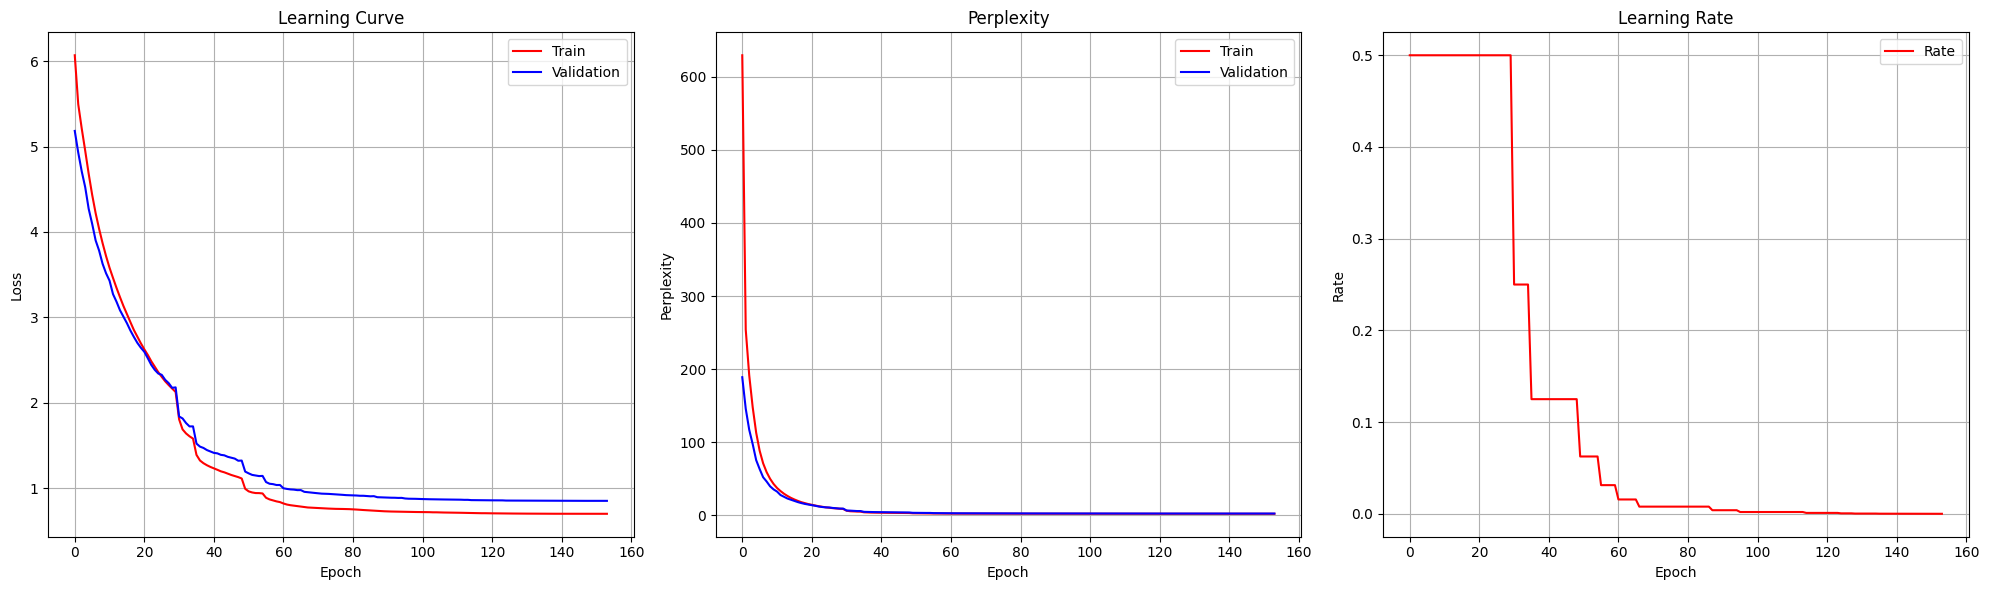

In [19]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [20]:
model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

Validation: Loss = 0.8529 , Perplexity = 2.38
Test: Loss = 0.8151 , Perplexity = 2.296


# Text Generation

In [21]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()
model

H_LSTM(
  (embedding): Embedding(33264, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33264, bias=True)
)

In [22]:
num_trainable_params(model)

39.309264

In [27]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [vocab[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = vocab_itos[next_token_id]
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            #if next_word in ["<eos>", "."]:
            #    break
            del next_token_id
    return generated_text

prompt = "I think the movie"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.4, 
                          model = model)

print(generated_text)

I think the movie their in World age another , made was reported dated from 1982 into the 2009 third four year . back coming financial conference . The was formed offering options the first time in the United States . The city &apos; s &lt; unk &gt; was &lt; unk &gt; and &lt; unk &gt; . = = = &lt; unk &gt; = = = The &lt; unk &gt; of the &lt; unk &gt; &lt; unk &gt; &lt; unk &gt; ( &lt; unk &gt; &lt; unk &gt; ) , and &lt; unk &gt; &lt; unk &gt; , &lt; unk &gt; &lt; unk &gt;
